## Import Dependencies:

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg

import scipy

In [14]:
FERTILIZER_VALUES = [1,2,3]
WATER_VALUES = [40,60,80]

DATASET_CSV_FILE = 'treefarm_dataset.csv'

In [15]:
def experiment_model(fertilizer, water):
    sunlight = np.random.normal(11,1)
    return sunlight, np.random.normal(1.5, 0.1) \
        + 0.125*sunlight \
        + 2.5 / (1 + 0.005*(water - 90)**2) \
        + 12.5 / (1 + np.exp(-0.1*(fertilizer - 2)))

## Generate Data

In [16]:
from itertools import product

data_columns = [
    'Fertilizer Type', 
    'Water (L/day)', 
    'Sunlight (hours/day)',
    'Tree Height (m)'
]

# data = []
# for (fertilizer,water) in product(FERTILIZER_VALUES, WATER_VALUES):
#     sunlight, result = experiment_model(fertilizer,water)
#     data.append((fertilizer,water,round(sunlight,2),round(result,2)))

# experiment_df = pd.DataFrame(data, columns=data_columns)
# experiment_df.to_csv(DATASET_CSV_FILE)

In [17]:
experiment_df = pd.read_csv(DATASET_CSV_FILE, usecols=data_columns)

display(experiment_df)

,Fertilizer Type,Water (L/day),Sunlight (hours/day),Tree Height (m)
0,1,40,12.63,9.09
1,1,60,9.62,9.00
2,1,80,11.60,10.56
3,2,40,9.46,9.15
4,2,60,9.63,9.45
5,2,80,12.07,10.84
6,3,40,10.39,9.53
7,3,60,9.98,9.81
8,3,80,11.58,11.16


In [18]:
before_df = experiment_df.copy()
before_df['Sunlight (hours/day)'] = '---'
before_df['Tree Height (m)'] = '---'

display(before_df)

,Fertilizer Type,Water (L/day),Sunlight (hours/day),Tree Height (m)
0,1,40,---,---
1,1,60,---,---
2,1,80,---,---
3,2,40,---,---
4,2,60,---,---
5,2,80,---,---
6,3,40,---,---
7,3,60,---,---
8,3,80,---,---


## Single Factor ANOVA Analysis

In [19]:
from scipy.stats import f_oneway

anova_df = experiment_df[['Fertilizer Type', 
    'Water (L/day)', 'Tree Height (m)']]

fertilizer_anova = pg.anova(dv='Tree Height (m)', 
                            between=['Fertilizer Type'], 
                            data=anova_df, 
                            detailed=True)
water_anova = pg.anova(dv='Tree Height (m)', 
                        between=['Water (L/day)'], 
                        data=anova_df, 
                        detailed=True)

display(fertilizer_anova)
display(water_anova)

,Source,SS,DF,MS,F,p-unc,np2
0,Fertilizer Type,0.574467,2,0.287233,0.368285,0.706541,0.109339
1,Within,4.679533,6,0.779922,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,Water (L/day),4.630467,2,2.315233,22.27852,0.001672,0.881322
1,Within,0.623533,6,0.103922,NaN,NaN,NaN


## Linear Regression Analysis:

In [20]:
w_is = []
for i in FERTILIZER_VALUES:
    df_i = experiment_df[experiment_df['Fertilizer Type'] == i]
    X_i, y_i = df_i.iloc[:,1:3].values, df_i.iloc[:,3].values
    X_i = np.hstack([X_i, np.ones((len(X_i),1)) ])
    w_i = np.linalg.pinv(X_i) @ y_i
    w_is.append(w_i)

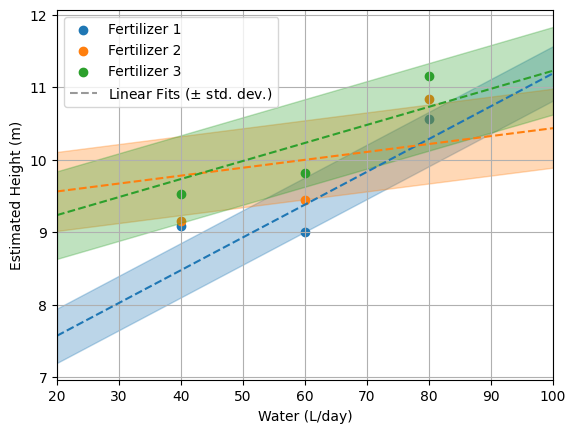

In [34]:
water_vals = np.linspace(20,100,200)
sunlight_mean = np.mean(experiment_df.iloc[:,2])
sunlight_std = np.std(experiment_df.iloc[:,2])

sigma = np.diag([0,sunlight_std**2,0])

plt.figure()
for i, w_i in zip(FERTILIZER_VALUES, w_is):
    col = next(plt.gca()._get_lines.prop_cycler)['color']
    X_i_eval = np.array([[w, sunlight_mean, 1] for w in water_vals])
    y_i_mean = X_i_eval @ w_i
    y_i_std = np.sqrt(w_i.T @ sigma @ w_i)
        
    df_i = experiment_df[experiment_df['Fertilizer Type'] == i]
    
    plt.scatter(df_i.iloc[:,1], df_i.iloc[:,3], label=f'Fertilizer {i}', color=col)
    plt.fill_between(water_vals,y_i_mean+y_i_std,y_i_mean-y_i_std, 
                     color=col, alpha=0.3)
    plt.plot(water_vals,y_i_mean, '--', color=col)

plt.xlim((20,100))
plt.xlabel('Water (L/day)')
plt.ylabel('Estimated Height (m)')
plt.grid()
plt.plot([],[],'k--', alpha=0.4, label=r'Linear Fits ($\pm$ std. dev.)')
plt.legend()
plt.show()

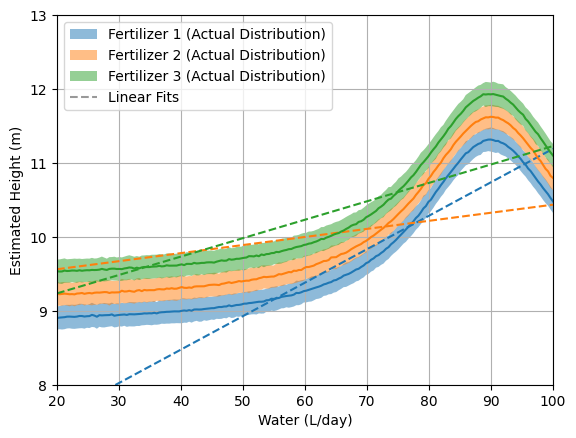

In [35]:
plt.figure()
for i, w_i in zip(FERTILIZER_VALUES, w_is):
    col = next(plt.gca()._get_lines.prop_cycler)['color']
    X_i_eval = np.array([[w, sunlight_mean, 1] for w in water_vals])
    y_i_mean = X_i_eval @ w_i
    y_i_std = np.sqrt(w_i.T @ sigma @ w_i)
    df_i = experiment_df[experiment_df['Fertilizer Type'] == i]
        
    exact_heights = np.array([ 
        np.mean([experiment_model(i, w)[1] for _ in range(1000) ])
        for w in water_vals 
    ])
    
    exact_height_stds = np.array([ 
        np.std([experiment_model(i, w)[1] for _ in range(1000) ])
        for w in water_vals 
    ])
    
    X_i_eval = np.array([[w, sunlight_mean, 1] for w in water_vals])
    y_i_mean = X_i_eval @ w_i
    
    plt.plot(water_vals,exact_heights, '-', color=col)
    plt.fill_between(water_vals, 
                     exact_heights+exact_height_stds,
                     exact_heights-exact_height_stds,
                     alpha=0.5, label=f'Fertilizer {i} (Actual Distribution)')
    
    plt.plot(water_vals, y_i_mean, '--', color=col)

plt.plot([],[],'k--', alpha=0.4, label='Linear Fits')
plt.xlim((20,100))
plt.ylim((8,13))
plt.xlabel('Water (L/day)')
plt.ylabel('Estimated Height (m)')
plt.grid()
plt.legend()
plt.show()

## Bayesian Modeling:

In [36]:
SELECTED_WATER = 80
N_SAMPLES_PER_FERTILIZER = 12

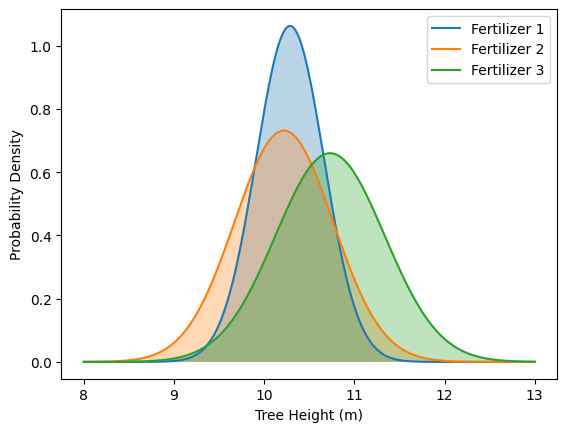

In [37]:
def linear_model_distribution(height, fertilizer, water):
    w_i = w_is[FERTILIZER_VALUES.index(fertilizer)]
    x_i_eval = np.array([[water, sunlight_mean, 1]])
    y_i_mean = np.dot(x_i_eval,w_i)
    y_i_std = np.sqrt(w_i.T @ sigma @ w_i)
    
    return scipy.stats.norm.pdf((height - y_i_mean), scale=y_i_std)

h_eval = np.linspace(8,13, 1000)

plt.figure()
for i in FERTILIZER_VALUES:
    densities = linear_model_distribution(h_eval, i, SELECTED_WATER)
    plt.plot(h_eval, densities, label=f'Fertilizer {i}')
    plt.fill_between(h_eval, densities, alpha=0.3)

plt.legend()
plt.xlabel('Tree Height (m)')
plt.ylabel('Probability Density')
plt.show()

In [38]:
def calculate_fertilizer_posterior(heights, prior):
    fertilizer_densities = np.array([
        linear_model_distribution(h_eval, i, SELECTED_WATER)*prior[i]
        for i in FERTILIZER_VALUES
    ])
    
    for j in range(fertilizer_densities.shape[1]):
        fertilizer_densities[:,j] /= np.sum(fertilizer_densities[:,j])
        
    return {
        i : row
        for i,row in zip(FERTILIZER_VALUES, fertilizer_densities)
    }
        

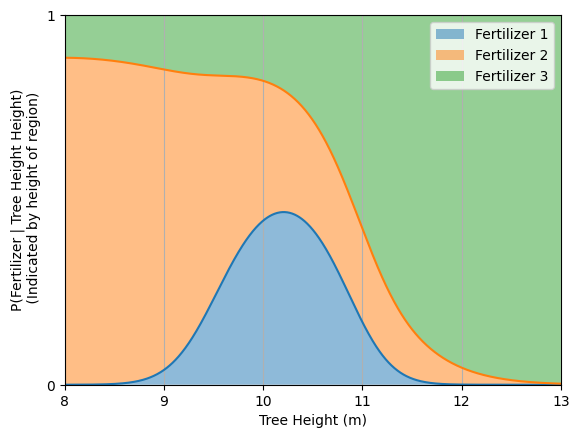

In [40]:
uniform_prior = {
    1 : 1/3,
    2 : 1/3,
    3 : 1/3,
}

uniform_posterior = calculate_fertilizer_posterior(h_eval, uniform_prior)

plt.figure()
last_vals = np.zeros_like(h_eval)
for i in FERTILIZER_VALUES:
    new_vals = last_vals + uniform_posterior[i]
    plt.plot(h_eval, new_vals)
    plt.fill_between(h_eval, last_vals, new_vals, label=f'Fertilizer {i}', alpha=0.5)
    last_vals = new_vals
plt.ylim((0,1))
plt.xlim((8,13))
plt.yticks([0.0, 1.0])
plt.xlabel('Tree Height (m)')
plt.ylabel('P(Fertilizer | Tree Height Height)\n (Indicated by height of region)')
plt.grid()
plt.legend()
plt.show()